<h1>Edad del Volumen - Histórico y Pronóstico Concreto - Variable auxiliar</h1>

El proposito de este notebook es obtener y hacer un pre-alistamiento de los datos correspondientes a la edad del volumen para que sea utilizada como variable predictora al momento de pronosticar el volumen de concreto.

Para ello se creará una red neuronal para alimentar el pronostico de los dias que aun no han transcurrido.

In [1]:
# Parte 1 - Preprocesado de los datos

# Importación de las librerías
import numpy as np
import pandas as pd
from keras.models import load_model
#import modulo_conn_sql as mcq
import datetime 

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

from io import BytesIO
import matplotlib.pyplot as plt
import seaborn as sns

Using TensorFlow backend.
/Users/jsdelgadoc/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/jsdelgadoc/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/jsdelgadoc/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/jsdelgadoc/opt/anacond

In [52]:
# Importar el dataset de entrenamiento
#dataset = obtenerDataTrain( pais, inicioHistoria.strftime("%Y-%m-%d"), finHistoria.strftime("%Y-%m-%d") )

df_edad = pd.read_excel("../datos/" + pais +"/" + pais +" EdadVolumen.xlsx")
df_edad['Edad'] = pd.to_datetime(df_edad['Fecha']) - pd.to_datetime(df_edad['PrimerConsumo'])
df_edad['Edad'] = df_edad['Edad'] / np.timedelta64(1,'D')
dataset = dataset.groupby(['Pais','Fecha']).agg({'Edad':['mean','median'], 'Vol':['sum']}).reset_index()
dataset.columns = ['Pais','Fecha', 'mean', 'median', 'Vol']

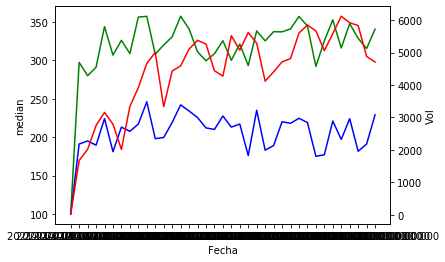

In [54]:
sns.lineplot(data = dataset[dataset['Fecha']>= '2021-01-01'], x = "Fecha", y ="mean", color="g")
sns.lineplot(data = dataset[dataset['Fecha']>= '2021-01-01'], x = "Fecha", y ="median", color="b")
ax2 = plt.twinx()
sns.lineplot(data = dataset[dataset['Fecha']>= '2021-01-01'], x = "Fecha", y ="Vol", ax=ax2, color="r")

In [67]:
#Parametros
pais = 'Colombia'      
inicioHistoria = datetime.datetime(2017, 1, 1) #'2013-05-01'
finHistoria = datetime.datetime.today() #fecha actual
fecha_split = '2021-02-08'

#Memoria corto plazo
timesteps = 5
#numero de neuronas
un = 600
#coeficiente de olvido
do = 0.2
#numero de ciclos
ep = 50

In [68]:
dataset_array = dataset.iloc[:, 3:4].values

#Defino el dataset de entrenamiento y el de test
dataset_train = dataset[ dataset['Fecha'] < fecha_split]
training_set  = dataset_train.iloc[:, 2:8].values

dataset_test = dataset[ dataset['Fecha'] >= fecha_split ]
test_set  = dataset_test.iloc[:, 2:8].values

# Escalado de características
sc = MinMaxScaler(feature_range = (0, 1))
dataset_array_scaled = sc.fit_transform(dataset_array)
training_set_scaled = sc.transform(training_set)
test_set_scaled = sc.transform(test_set)

In [69]:
#ESTRUCTURA DE LA RED NEURONAL RECURRENTE

#defino un array por cada variable predictora
X_train = []
X_train_material = []


y_train = []

for i in range(timesteps, len(training_set)):
    #columna 0 -> Cantidad Material
    X_train_material.append( training_set_scaled[i-timesteps:i, 0])
    
    y_train.append(training_set_scaled[i, 0])

#se convierten los array en objetos numpy    
X_train_material = np.array( X_train_material)

y_train = np.array(y_train)

#Se agrega una nueva dimension a las variables
X_train_material = np.reshape(X_train_material, (X_train_material.shape[0], X_train_material.shape[1], 1 ))

X_train = X_train_material

#inicializacion del regresor
regressor = Sequential()

#añadir la primera capa de LSTM y la regularización por Dropout
regressor.add(LSTM(units=un, return_sequences = True, input_shape=(X_train.shape[1], X_train.shape[2])))
regressor.add(Dropout(do))

#añadir nueva capa LSTM
regressor.add(LSTM(units=un, return_sequences = True))
regressor.add(Dropout(do))

#añadir nueva capa LSTM
regressor.add(LSTM(units=un, return_sequences = True))
regressor.add(Dropout(do))

#añadir nueva capa LSTM
regressor.add(LSTM(units=un, return_sequences = True))
regressor.add(Dropout(do))

#añadir nueva capa LSTM
regressor.add(LSTM(units=un, return_sequences = True))
regressor.add(Dropout(do))

#añadir nueva capa LSTM
regressor.add(LSTM(units=un, return_sequences = True))
regressor.add(Dropout(do))

#añadir nueva capa LSTM
regressor.add(LSTM(units=un, return_sequences = True))
regressor.add(Dropout(do))

#añadir penultima capa
regressor.add(LSTM(units=un))
regressor.add(Dropout(do))

#añadir capa de salida
regressor.add(Dense(units=1))

#compilar la RNR
regressor.compile(optimizer = 'adam', loss='mean_squared_error')

In [70]:
#ajustar la RNR al conjunto de entrenamiento
regressor.fit(X_train, y_train, epochs=ep, batch_size = 512)

Epoch 1/50
2193/2193 [==============================] - 14s 6ms/step - loss: 0.0348
Epoch 2/50
2193/2193 [==============================] - 11s 5ms/step - loss: 0.0097
Epoch 3/50
2193/2193 [==============================] - 11s 5ms/step - loss: 0.0098
Epoch 4/50
2193/2193 [==============================] - 11s 5ms/step - loss: 0.0061
Epoch 5/50
2193/2193 [==============================] - 11s 5ms/step - loss: 0.0040
Epoch 6/50
2193/2193 [==============================] - 11s 5ms/step - loss: 0.0046
Epoch 7/50
2193/2193 [==============================] - 11s 5ms/step - loss: 0.0037
Epoch 8/50
2193/2193 [==============================] - 11s 5ms/step - loss: 0.0037
Epoch 9/50
2193/2193 [==============================] - 11s 5ms/step - loss: 0.0037
Epoch 10/50
2193/2193 [==============================] - 11s 5ms/step - loss: 0.0035
Epoch 11/50
2193/2193 [==============================] - 11s 5ms/step - loss: 0.0035
Epoch 12/50
2193/2193 [==============================] - 11s 5ms/step - lo

In [71]:
#obtener prediccion del material entregado con la RNR 

#los inputs van a ser los ultimos Timesteps dias del training set, para predecir el primer dia 
inputs = training_set_scaled[len(training_set_scaled) - timesteps: ]

for j in range (0, test_set_scaled.shape[0] ):
    X_test = []
    X_test_material = []


    for i in range(timesteps, inputs.shape[0]+1 ):

        #columna 0 -> Cantidad Material
        X_test_material.append( inputs[i-timesteps:i, 0])

    #se convierten los array en objetos numpy    
    X_test_material = np.array( X_test_material)
    
    #Se agrega una nueva dimension a las variables
    X_test_material = np.reshape(X_test_material, (X_test_material.shape[0], X_test_material.shape[1], 1 ))
    
    #se crea el la estructura de datos que se le va a pasar al regresor
    X_test =X_test_material

    # por fin, ejecutar prediccion
    prediction = regressor.predict(X_test)

    #a la prediccion le agrego las demas variables predictoras
    prediction = np.append(prediction, (test_set_scaled[:len(prediction), 1 : ]), axis=1 )

    inputs = training_set_scaled[len(training_set_scaled) - timesteps:]

    inputs = np.append(inputs, (prediction), axis=0 )
    
prediction = sc.inverse_transform(prediction)

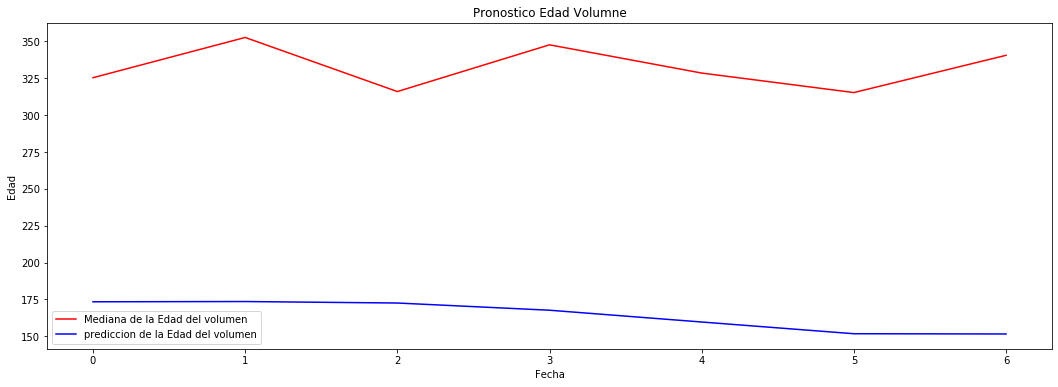

In [72]:
plt.figure(figsize=(18,6))
plt.plot(test_set[: , 0], color = 'red', label = 'Mediana de la Edad del volumen')
plt.plot(prediction[:, 0:1], color = 'blue', label = 'prediccion de la Edad del volumen')
plt.title('Pronostico Edad Volumne')
plt.xlabel('Fecha')
plt.ylabel('Edad')
plt.legend()
plt.show()